## Import libraries
![](https://miro.medium.com/v2/resize:fit:1400/1*rCBaaTl0hvPGPcID7ulqPg.png)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch 
import random
import json
import time
import datetime
import os

from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, AdamW, get_linear_schedule_with_warmup

### configuration 

In [24]:
configer = {
    "device": "cuda" if torch.cuda.is_available() else "cpu" , 
    "model_name"  :  "gpt2-medium" , 
    "model_save_path" :  './model' , 
    "data_path" : "/kaggle/input/joypoem/joy.json",
    "batch_size" : 8 , 
    "max_length" : 100 , 
    "seed_val" : 42 , 
    "epochs" : 2 ,
    "warmup_steps" : 1e2,
}
random.seed(configer["seed_val"])
np.random.seed(configer["seed_val"])
torch.manual_seed(configer["seed_val"])
torch.cuda.manual_seed_all(configer["seed_val"])

In [25]:
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler

##  Prepare a Dataset

In [27]:
with open(configer['data_path']) as f : 
    data = json.load(f)

data = [poem for poem in data if len(poem["poem"].split()) < 100]
print(len(data))
data[:5]

32444


[{'poem': 'And he wooed her with caresses,\nWooed her with his smile of sunshine,\nWith his flattering words he wooed her,\nWith his sighing and his singing,\nGentlest whispers in the branches,\nSoftest music, sweetest odors,\nTill he drew her to his bosom,\nFolded in his robes of crimson,\nTill into a star he changed her,\nTrembling still upon his bosom;\nAnd forever in the heavens\nThey are seen together walking,\nBut the fierce Kabibonokka\nHad his dwelling among icebergs,\nIn the everlasting snow-drifts,\nIn the kingdom of Wabasso,\nIn the land of the White Rabbit.',
  'id': 30},
 {'poem': 'Once, as he was gazing northward,\nFar away upon a prairie\nHe beheld a maiden standing,\nSaw a tall and slender maiden\nAll alone upon a prairie;\nBrightest green were all her garments,\nAnd her hair was like the sunshine.',
  'id': 43},
 {'poem': "Till one morning, looking northward,\nHe beheld her yellow tresses\nChanged and covered o'er with whiteness,\nCovered as with whitest snow-flakes.",

In [28]:
class PoemDataset(Dataset):
  def __init__(self, poems, tokenizer, max_length=768, gpt2_type="gpt2"):
    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for poem in poems:

      encodings_dict = tokenizer("<|startoftext|>"+poem["poem"]+"<|endoftext|>",
                                 truncation=True,
                                 max_length=max_length,
                                 padding="max_length")
      
      self.input_ids.append(torch.tensor(encodings_dict["input_ids"]))
      self.attn_masks.append(torch.tensor(encodings_dict["attention_mask"]))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

In [29]:
# Loading GPT2 Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')

In [30]:
print(tokenizer.encode("<|startoftext|> Hello World <|endoftext|>", padding="max_length", max_length=10))
print(len(tokenizer))

[50257, 18435, 2159, 220, 50256, 50258, 50258, 50258, 50258, 50258]
50259


In [31]:
# Finding length of maximum token in dataset
max_length = max([len(tokenizer.encode(poem["poem"])) for poem in data])
print(max_length)
max_length = 100

345


In [11]:
x = [len(tokenizer.encode(poem["poem"])) for poem in data if len(tokenizer.encode(poem["poem"])) < 100]

In [12]:
y = [len(tokenizer.encode(poem["poem"])) - len(poem["poem"].split()) for poem in data]

<function matplotlib.pyplot.show(close=None, block=None)>

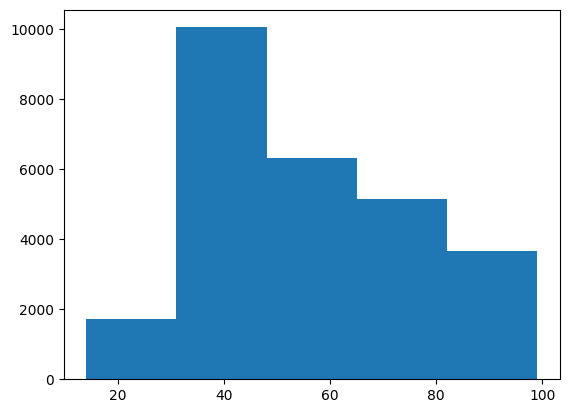

In [13]:
plt.hist(x, bins = 5)
plt.show

In [32]:
dataset = PoemDataset(data, tokenizer, max_length=max_length)

# Split data into train and validation sets
train_size = int(0.9*len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print("Number of samples for training =", train_size)
print("Number of samples for validation =", val_size)

Number of samples for training = 29199
Number of samples for validation = 3245


In [15]:
train_dataset[0]

(tensor([50257,  5122, 14919,    11,   262,  5156,   326,   537,  2150,   284,
         11906, 10329,    11,   198,  1870,   778, 43535,  1088, 17903,   287,
         11212,   500,   308,  7197,    11,   198, 19242,  7334,   510,    11,
           673,   338,  6405,   290,   734, 24924,  3383,  6510,   198, 11980,
         33091,   287,   607, 37284,   296,   257, 29420,   286,  8716,    82,
            13, 50256, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [33]:
train_dataloader = DataLoader(train_dataset,
                              sampler=RandomSampler(train_dataset),
                              batch_size=configer["batch_size"])

val_dataloader = DataLoader(val_dataset,
                            sampler=SequentialSampler(val_dataset),
                            batch_size=configer["batch_size"])

# Finetune GPT2 Language Model

In [34]:
# Load model configuration
confige = GPT2Config.from_pretrained("gpt2")

# Create model instance and set embedding length
model = GPT2LMHeadModel.from_pretrained("gpt2", config=confige)
model.resize_token_embeddings(len(tokenizer))

# Running the model on GPU
model = model.to(configer["device"])

In [35]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50259, bias=False)
)


In [36]:
# Using AdamW optimizer with default parameters
optimizer = AdamW(model.parameters(), lr=5e-4, eps=1e-8)

# Toatl training steps is the number of data points times the number of epochs
total_training_steps = len(train_dataloader)*configer["epochs"]

# Setting a variable learning rate using scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=configer["warmup_steps"],
                                            num_training_steps=total_training_steps)

In [38]:
def format_time(elapsed):
  return str(datetime.timedelta(seconds=int(round(elapsed))))
total_t0 = time.time()

training_stats = []
device = "cuda"
model = model.to(device)
sample_every = 100

for epoch_i in range(configer["epochs"]):
  print(f'Beginning epoch {epoch_i+1} of {configer["epochs"]}')

  t0 = time.time()
  total_train_loss = 0
  model.train()

  # Labels are shifted by 1 timestep
  for step, batch in enumerate(train_dataloader):
    b_input_ids = batch[0].to(device)
    b_labels = batch[0].to(device)
    b_masks = batch[1].to(device)

    model.zero_grad()

    outputs = model(b_input_ids,
                    labels=b_labels,
                    attention_mask=b_masks)
    
    loss = outputs[0]

    batch_loss = loss.item()
    total_train_loss += batch_loss

    # Sampling every x steps
    if step != 0 and step % sample_every == 0:

      elapsed = format_time(time.time()-t0)
      print(f'Batch {step} of {len(train_dataloader)}. Loss: {batch_loss}. Time: {elapsed}')

      model.eval()

      sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
      for i, sample_output in enumerate(sample_outputs):
        print(f'Example ouput: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
      print()

      model.train()

    loss.backward()
    optimizer.step()
    scheduler.step()

  avg_train_loss = total_train_loss / len(train_dataloader)
  training_time = format_time(time.time()-t0)
  print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')
  print()

  t0 = time.time()
  model.eval()

  total_eval_loss = 0
  nb_eval_steps = 0

  for batch in val_dataloader:
    b_input_ids = batch[0].to(device)
    b_labels = batch[0].to(device)
    b_masks = batch[1].to(device)
        
    with torch.no_grad():        

        outputs  = model(b_input_ids,  
                         attention_mask = b_masks,
                         labels=b_labels)
          
        loss = outputs[0]  
            
    batch_loss = loss.item()
    total_eval_loss += batch_loss   

  avg_val_loss = total_eval_loss / len(val_dataloader)  
  val_time = format_time(time.time() - t0)    
  print(f'Validation loss: {avg_val_loss}. Validation Time: {val_time}')
  print()

  # Record all statistics from this epoch.
  training_stats.append(
      {
          'epoch': epoch_i + 1,
          'Training Loss': avg_train_loss,
          'Valid. Loss': avg_val_loss,
          'Training Time': training_time,
          'Validation Time': val_time
      }
  )
  print("------------------------------")

print(f'Total training took {format_time(time.time()-total_t0)}')

Beginning epoch 1 of 2
Batch 100 of 3650. Loss: 2.890007972717285. Time: 0:00:14


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Example ouput:  bipartisanThought of a sweet little bird
Where her pride could shine
And the white-trees bloom above,
And the sun
Of the sun's shine--
A true sweet angel
That is an ideal gift,
And joy was the joy to him.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 200 of 3650. Loss: 2.7083098888397217. Time: 0:00:29
Example ouput:  increasing"Now the king says, with a gentle voice, 'God gave thee some power'--
"No words can convey this gift when there is no power--
"No words can convey it when there is no power--
"No other power is this."
That same same hour,
And the other thing had come;
And the other things came; the other stuff had come.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 300 of 3650. Loss: 3.6423821449279785. Time: 0:00:43
Example ouput: dayOh, how fair they are, to you,
As you love a baby,
So sweet is they all--
Oh, how fair they are the world,
And it's like the world's beauty.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 400 of 3650. Loss: 2.9010021686553955. Time: 0:00:57
Example ouput:  HangHang it up with me.  She is a good girl
For my love, and I love her better than I.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 500 of 3650. Loss: 2.797327756881714. Time: 0:01:11
Example ouput:  foodsThen the starlet, that on her birth, with her mother's tender care
Had sung for the blessed and the sweet;
She gazed to the starlet, who, of oldest,
Had told him that she was born!
What she said is not her love's true name:
A youth so radiant as her eyes
Caught her as that the starlet.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 600 of 3650. Loss: 4.027545928955078. Time: 0:01:26
Example ouput:  trailO, thou hast told, a friend,
Who was a child,
A child,
A youth,
A girl, a youth who was
A child of God!
O blessed Saviour!
My child,
O O blessed Saviour!
And when this beaming youth
Shan be mine now,
O'en its joy, its love!
O thou hast a son of mine!
As thou hast a love for her,
My heart is not in her heart
When thou hast found no way.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 700 of 3650. Loss: 3.118462085723877. Time: 0:01:40
Example ouput: intendO, how sweet, how delicious!
My love, my faith! my heart, that were so dear to me,
The pride of all the world! my soul, that were so fond,
Had a joyous glow that was in it,
And that in my eyes and ears were not so joyous.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 800 of 3650. Loss: 2.399233102798462. Time: 0:01:55
Example ouput:  surroundNow, in his home the garden
The roses of flowers
Can grow, but can fall,
Now in my garden the roses
May be growing,
Now in my garden the roses
Will grow.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 900 of 3650. Loss: 2.5051345825195312. Time: 0:02:09
Example ouput:  reflexShe fell from a mother's home, but
For her daughter had come by and watched
The children play the game of a child
Who used to love the mother of a child.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 1000 of 3650. Loss: 3.104597330093384. Time: 0:02:23
Example ouput:  displayFor the dear of the world is thy soul;
And from thy goodly eye you behold
The brightness that flows from the bright stream
Of beauty's purest ray;
And then with thy gentle love I take
The sweet of thy eyes that swim and swim
Like a stream, the bright light of their soft waves.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 1100 of 3650. Loss: 2.702455520629883. Time: 0:02:37
Example ouput:  pastorAnd if you cannot love
Your soul, I will praise thee;
If not your will
My little heart will be more
Like an angel's kiss.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 1200 of 3650. Loss: 3.228431463241577. Time: 0:02:51
Example ouput:  illicitThat this may be, if it will be so
That no heart shall ever be as pleased
With pleasure, and with rest.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 1300 of 3650. Loss: 2.930875301361084. Time: 0:03:05
Example ouput:  LiberationHark to that tale of the young woman, that said she
Was just starting to love her young bride,
And gave her the blessing of her daughter, who was young
With her head and chin.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 1400 of 3650. Loss: 2.8058364391326904. Time: 0:03:19
Example ouput:  NamHe had a great-eyed youth with a smile,
And bright, and fair, and slender,
With an angel's hand around his waist,
And had fair, and fair, and rosy hair
On his chin, and brow, and waist,
But not with a man's smile.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 1500 of 3650. Loss: 2.335063934326172. Time: 0:03:33
Example ouput: IONAnd, smiling, we stroked together,
And shook, and spied him.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 1600 of 3650. Loss: 3.029798746109009. Time: 0:03:47
Example ouput:  glimpseYet, as that is true, it will not die away
Unto our feet, and thus we shall meet
Where we may sit and talk with love and wonder
On earth alone, and we shall see and see
What nature can give, we will not reach the dead,
We will not reach the dead
And the spirits of our feet shall rise to meet
With one-starlight, and we will meet the old,
And our thoughts, which yet, with love's delight,
Our heads shall rejoice! and our thoughts shall rise, and joy to our death
And love our sorrows come and fade!
And we shall come unto our Lord, and the dead;
And the living things, and the dead will stay!
And we may be, and no more than we will be,
For, oh! for, oh! for the living in God's death I say,
I love us evermore, oh God will I



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 1700 of 3650. Loss: 2.8739728927612305. Time: 0:04:02
Example ouput:  LaureAnd we were all at play and chatting,
By the little green tree-back by the old woodside.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 1800 of 3650. Loss: 2.561677932739258. Time: 0:04:16
Example ouput: ismA moment longer, and in it seemed
The more for me than for me.  I had no time
Not to ask her what she was doing or saying,
But to do her with her, and to give her the chance
She was but one and I was not two.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 1900 of 3650. Loss: 2.927614212036133. Time: 0:04:30
Example ouput: ounAnd, with pride, a score of friends
With friendly deeds the proud,
The noble, the true,
The valiant, the brave,
And of his own country.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 2000 of 3650. Loss: 3.3693103790283203. Time: 0:04:45
Example ouput:  electionThen I told the young world, as I thought I might,
The aged folk, who, by the look of love,
Were always looking to find her to pay.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 2100 of 3650. Loss: 1.7165404558181763. Time: 0:04:59
Example ouput:  crazyFor to the land they were given;
To the land I sought;
For they are blessed and true:
But they who gave
The right to the land.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 2200 of 3650. Loss: 1.8582451343536377. Time: 0:05:13
Example ouput:  benchOh! if he could not love with this,
He would give it to a wife,--
I was sure with love I should have it.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 2300 of 3650. Loss: 2.271172523498535. Time: 0:05:27
Example ouput:  incorporatedFrom his hand she strode on the lea,
For a woman has always been a friend;
And a man has always been a friend.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 2400 of 3650. Loss: 2.7129812240600586. Time: 0:05:41
Example ouput: PeterAnd yet, for you are no longer!  And may I
And you and I live, and you may live, and you be strong.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 2500 of 3650. Loss: 3.3063347339630127. Time: 0:05:55
Example ouput: uringA mother's care could not fail,
Beneath his soul a mother's grace
Had sought a woman's care,
And a mother's faith.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 2600 of 3650. Loss: 2.8468263149261475. Time: 0:06:08
Example ouput:  reproductiveAnd the day before, the days before,
When all I had loved, was done;
No one saw my eyes,--the smiling faces
That came o'er my hair.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 2700 of 3650. Loss: 2.0729362964630127. Time: 0:06:23
Example ouput:  zoneOh, how bright is the glow o'er the night!
Ah, what mayst thou guess?
But oh! it is a dream;
And the suns are brighter far
Than evermore; but God is wise.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 2800 of 3650. Loss: 2.561501979827881. Time: 0:06:37
Example ouput:  commitsOh! no one knows him well,
As yet for my eyes,
As yet for me.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 2900 of 3650. Loss: 2.9675798416137695. Time: 0:06:51
Example ouput:  ironyThat he is a little girl,
And he is so small in life,
And so much a lovely child,
How could I not see the joy
It took me, to live in that house,
Or to live in there?
I heard there, a little boy
With a little girl that
Was in the garden
And never was so young.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 3000 of 3650. Loss: 2.372044801712036. Time: 0:07:05
Example ouput:  SahHe shall love in all his joys a daughter fair
And bright, with many a tender face and sweet,
Though she be as white as some great dream of yore.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 3100 of 3650. Loss: 2.7569022178649902. Time: 0:07:19
Example ouput:  BryanYet the young moon, whose beams so light,
Will bless his bride, all the day long,--
To make this a happy marriage
Is all the while the wedding-day closes.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 3200 of 3650. Loss: 2.4222934246063232. Time: 0:07:33
Example ouput:  spiritsThy wretchly brows with gold, thy eyes with gold,
And thou, my heart, as thine, the poet's darling,
With golden curls on thy breast I wove,
And all my soul within a blissful ecstasy,
And breathed a thousand things in thy song.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 3300 of 3650. Loss: 2.5716464519500732. Time: 0:07:47
Example ouput:  seesThus it flows on the whole world,
Its music still makes, the whole world sings;
Such thoughts I think of the whole world alone,
The whole world of living content to be,
The whole world of joy and of peace to be.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 3400 of 3650. Loss: 2.362694025039673. Time: 0:08:02
Example ouput:  hungryI love the sunbeam's sweet beam,
My God that crowns my beauty is blue,
And I know my own darling is not here.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 3500 of 3650. Loss: 2.587599039077759. Time: 0:08:16
Example ouput:  PTThat's to say I love her:
Her beauty's like the grass;
Her hair and her eyes are dim;
For so many lovely things,
And each must have its own.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 3600 of 3650. Loss: 3.039539337158203. Time: 0:08:30
Example ouput: üWe met in this place--the beautiful land where the rose
is fair and fair. It is the land where the sweetest, the purest
The most pure is the land for its pureest.

Average Training Loss: 2.759377619371022. Epoch time: 0:08:37

Validation loss: 2.546522978197765. Validation Time: 0:00:16

------------------------------
Beginning epoch 2 of 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 100 of 3650. Loss: 2.169710159301758. Time: 0:00:14
Example ouput: ruceI'll be rich in the world when they pass away,
When they are over, when they are over,
And I'll give you my money back at the dawn.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 200 of 3650. Loss: 2.7142958641052246. Time: 0:00:28
Example ouput:  derivativesThere, like a shadow of the mountains
Upon the hillside glows; and the sunlight
Distills into every bosom
A silver shadow of the deep.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 300 of 3650. Loss: 2.4854860305786133. Time: 0:00:42
Example ouput: But let me go on in my journey home
To the garden, where the white blossoms are growing;
To the field where the little streams are growing,
Where the white mist from the snow has lided about.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 400 of 3650. Loss: 2.5179097652435303. Time: 0:00:56
Example ouput:  rememberingMy eyes have no joy, no light,
Only the night of delight--
_Charm me, ye spheres of air,
And let me, when you will,
Accord me to thy happy home,
And I may rest no longer here._
_The song of the wild wood gliding
With the birds of its own wild strain._
The songs of the earth are like a song,--
_The music of the sea,
_The sound of the waters._
The world sings of music as its chords move._
A little, shadowy river, clear and clear,
A floating rill,
Of strange and strange music, that no friend had found,
But one sweetened a tune.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 500 of 3650. Loss: 2.6803596019744873. Time: 0:01:11
Example ouput:  SourcesThey left her by the hedge
All freshly wet;
And they stood by the beach
Praying, waiting, waiting, waiting,
Crying--"Come, dear, come, love, come!"
Here came the beautiful Rose,
A rose so white that leaves the seas,
A pretty rose white and red--
All wept and prayed together;
And here we went--
And here we sat,--
And I said--
And here we went--and here we stood;
I said--"What's our lives, dear Rose,
Our songs are still fresh and fair,
And our voices still true--
Rose.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 600 of 3650. Loss: 2.786501884460449. Time: 0:01:26
Example ouput: ems'O Willy, ye hills and meadows!  O Willy, ye hills and meadows!
Thy soul with love will be so fair and true to me;
Mine eyes will burn with your love for me!'
I went to sleep, but the roses flew in the gloom;
I woke in the morning, I woke in the morning;
'O Willy, my love, I'll break my heart to hear me say.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 700 of 3650. Loss: 2.8621604442596436. Time: 0:01:40
Example ouput: tzI did not forget the joy of the sunshine in your eyes
That in your life--and yours--all things that we love best--
To bring to each other a glory--
A glory of light and light and gladness.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 800 of 3650. Loss: 2.409123420715332. Time: 0:01:55
Example ouput: maticThou know'st what I think, O Lord,
As thou com'st, Thou art in fashion
Of a perfect pair: thou hast a
Perfection of soul and body
That's fit for one; a perfection of heart
By thy love's great Maker, is given.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 900 of 3650. Loss: 2.328606367111206. Time: 0:02:09
Example ouput:  syndBut the soul that's not kind
To hear its little child
Shall learn to love and be glad
And keep it as we please,
And to be sure we'll have it right
When we meet in Heaven.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 1000 of 3650. Loss: 3.17928409576416. Time: 0:02:23
Example ouput:  gamThy love to me is a prize;
Thy smile is like the gold of the sun,
Thou makest the world a living treasure,
Thy wealth to me is as a prize.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 1100 of 3650. Loss: 1.9372800588607788. Time: 0:02:37
Example ouput:  injuryCome, O happy land!
With thy sombre waters run!
In thy deep and sunny bowers
The birds of May proclaim.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 1200 of 3650. Loss: 1.9921625852584839. Time: 0:02:51
Example ouput: azaHe'll give me all I ask in his glee,
And I'll see him for his joyous fight,
And the glorious return of his day.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 1300 of 3650. Loss: 2.5550386905670166. Time: 0:03:05
Example ouput:  membraneI had planted, from the first harvest of a seed,
A tree with branches green, by the second season, when it grew,
A lily with blossoms green and yellow as a flower,
A rose, a little lily in its early bloom,
A little maiden with rosy cheeks flushed
With many tears and tears, as though to have them all done,
The blossoms of the day in the garden bloom,
And as the breeze touched the apple-trees, and made it seem
A blossom white and yellow, and white.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 1400 of 3650. Loss: 3.187415838241577. Time: 0:03:20
Example ouput: ijing"Here will I be, with a smile for all my life,
"When I was a child and I was a virgin child
"And my heart made music; she went in the grass
"To play with me and in the grass;
"She laughed in her glee in the rain,
"To weep in the trees. Her footsteps drew
"From the trees a little murmur, "Oh, me!
"He told me that he always loved me,
"When he said he couldn't tell if his hand was bent,
"He called me a little bird.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 1500 of 3650. Loss: 2.4611940383911133. Time: 0:03:35
Example ouput:  castThe birds are not the trees, but the grasses of the sea
That gush and shine with a new and tender mien,
And yet the fresh earth is full of beauty and gladness
When I sing to her in the blue sea.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 1600 of 3650. Loss: 2.1721346378326416. Time: 0:03:49
Example ouput:  purchI loved the woman who spoke
What I not saw: I walked in her pride
And saw the lovely creature in the night
Singing her fair name on his own,
And seeing her, with a glad surprise,
Passed the last and the last day's golden day.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 1700 of 3650. Loss: 2.300527334213257. Time: 0:04:03
Example ouput:  shouldersThe birds at the door
Are full of merry rejoicing,
And the moon, with her starry ray,
Hath kindly come and feasted.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 1800 of 3650. Loss: 2.1736114025115967. Time: 0:04:17
Example ouput:  built"Thou art God, and God too hast made;
Wherewith are thy deeds now undone?
But this is thy day--not to be undone!
Why, where is thy joy now, that is in thy sight?
O wert thou no more in glory, when thou art in need?
Thou art a child now, but thou hast grown
A splendid and a mighty manger.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 1900 of 3650. Loss: 2.1581709384918213. Time: 0:04:31
Example ouput:  openlyAs the sunshine through the leaves
Dyes, where we walk before them,
So soft, so bright, so pure and low,
I would have walked down by the stream
To gaze upon a child I had never known.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 2000 of 3650. Loss: 1.8054951429367065. Time: 0:04:45
Example ouput:  haltedWhence come thou with those two?
Whence come the little girl who I love?
And in the olden time, when I was still
Full of love for thee,
As still I was, I shall be true,
She is our darling child.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 2100 of 3650. Loss: 2.6481330394744873. Time: 0:04:59
Example ouput:  NikWe'll dance upon the grass, the flowers will sing;
We'll dance on the grass and roses, and our lances will sing.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 2200 of 3650. Loss: 2.0532796382904053. Time: 0:05:13
Example ouput:  tinTo my little book I've drawn my pen,
And drawn my verse from the book;
And all my hopes to triumph have lain
Three score years since these wretched pages were laid.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 2300 of 3650. Loss: 2.5112318992614746. Time: 0:05:27
Example ouput:  clinicalAnd when he said of his wife
She looked at him in astonishment
"How many years have I had to tell you,
Have I tried so hard to tell you,
Have I tried to hold you in my arms?
Oh, so much have I tried to hold you,
Yet your love is stronger than life."
Thereafter, being quite alone,
He said, "I love my wife, and I
Are all but empty-handed."
"Nay, don't tell me how," she laughed;
"I don't have any sense
You would guess who the reason was
Why you loved me so,
And why you loved me so hard
Was I, my only thinking.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 2400 of 3650. Loss: 2.321091413497925. Time: 0:05:42
Example ouput: lectionsAnd all that is, all that nature did,
Was in the soul of the Lady God:
The Lady God of the Past, the Lady God above,
The Lady of the Past, the Lady of the Present,
The Lady of the Present, the Lady of the Past,
Whom all love and beauty from the lips did feed,
But that is the heart of our Lady God.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 2500 of 3650. Loss: 2.145557403564453. Time: 0:05:57
Example ouput: elsNo, my dear, but for the love that we
Wax, and fading, fading, as it passed
By.                                                                                                                                                                             



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 2600 of 3650. Loss: 2.3601579666137695. Time: 0:06:12
Example ouput: labI know them no more than here
That one day they were all a merry song;
Their songs were like that,
And their eyes like that are glows above.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 2700 of 3650. Loss: 2.4386074542999268. Time: 0:06:26
Example ouput:  tripleHow is it that my soul to be
With joy like thee, when I hear
Such words as these utter at thy command,
And all thy tenderness with such sweetness,
As those thine own lips so lips that they seem
Too warm to hold for being love,
Too dear for love,--so love, too dear for death?
The earth is fair
When she bends above thee,
And she is fair.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 2800 of 3650. Loss: 1.8128230571746826. Time: 0:06:40
Example ouput: 220My dear-love is dead,--
And she is dead:
On the other side, on the lake,
A sea of foam and a sea of snow
The beautiful and the gray.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 2900 of 3650. Loss: 2.6076481342315674. Time: 0:06:54
Example ouput:  See"Now to him the light of thy rising rays
Shall on the great angel wing,
And bless the earth with his eternal beam;
And all that I desire shall be thine."
Thus did the angel, with a smile benign,
And with a voice more joyful rang,
Than if by mortal hands he had been,
And in his angel's sight each word had breathed
Its gladness and exultation.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 3000 of 3650. Loss: 2.343721866607666. Time: 0:07:09
Example ouput: @@What love are those arms which give you up,
Laughing to think how much they lose,
When the cold, heavy earth looks round,
Like one of a dead mother's lips to smile,
Like the dead mother's cradle to kiss,
Like that mother's prayer, 'O blessed Child!'
My heart hath a secret hidden part
To hide its joys in the face of the dead:
It is a hidden book, hidden from thought,
Where only love is born from the heart.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 3100 of 3650. Loss: 2.3726284503936768. Time: 0:07:23
Example ouput:  hostIt is not our pride to see her face,
We love her with a love as deep,
Like light upon a dark sea to gaze,
Or love her with a love like ours.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 3200 of 3650. Loss: 2.1402485370635986. Time: 0:07:37
Example ouput: roleHow happy I am to see you
When you come home to my little children."
He then went to work at iron,
He then left the children to his wife,
His wife and children brought him meat.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 3300 of 3650. Loss: 2.104379415512085. Time: 0:07:52
Example ouput: iacFrom his own heart, by some strange power
His heart was set in his lady's name,
And love was his womanhood.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 3400 of 3650. Loss: 2.214059591293335. Time: 0:08:05
Example ouput:  LDOh, we are not proud to boast to be rich in the
that we are great, but our love for the poor is far more than
this is our pride to be poor.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 3500 of 3650. Loss: 1.7231409549713135. Time: 0:08:19
Example ouput:  ListenThou mayst win the beauty of thy name,
The glory of thy line;
Thou mayst be my lover,
The glory of thy name.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Batch 3600 of 3650. Loss: 1.7405123710632324. Time: 0:08:33
Example ouput:  dyHer eyes are twinkling bright;
And their beauty lies apart
Like some long-lifted gem;
Her spirit, like a star,
Shines through her glassy screen.

Average Training Loss: 2.251755937648146. Epoch time: 0:08:41

Validation loss: 2.4403069788599248. Validation Time: 0:00:16

------------------------------
Total training took 0:17:49


## Visualizations

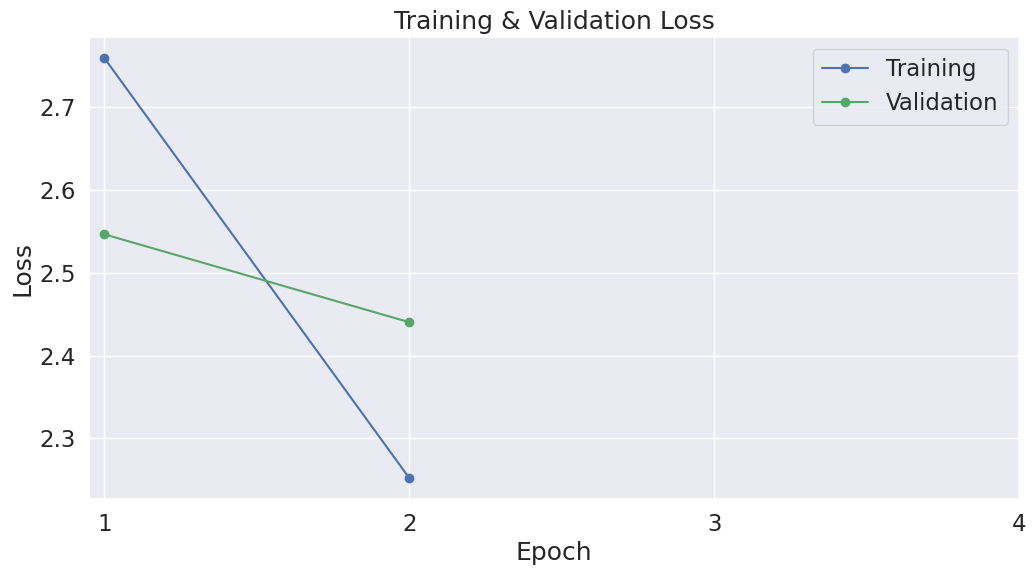

In [40]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## Generate Poems

In [41]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


0: There is naught to thee, darling,
Canst thou delight to see
Thy beautiful form again,
In sunshine or in rain.


1: Here he is the garden of my dreams,
The flowery seat and happy seat,
The sweet open door
Of the forest of my heart,
The light of the evening stars.


2: The birds sang aloud,--"O bird of praise,
This leaf is bright as the sun!"
And the bumble-bee, cooing low,
And the cricket, cooing low,
Said, "Where are the sweetest flowers?"
And the bluebird, cooing low,
Said, "Where are the sweetest flowers?"
And the blackbird cooing low.


